# Retail Sales Analysis & Time Series Forecasting

## Executive Summary

This project analyzes five years of retail sales data to uncover sales trends,
seasonality patterns, and key business drivers. The dataset was cleaned to
address missing values, inconsistent product and category labels

## Key Insights & Business Recommendations

### Key Insights
1. **Sales Trends:** Monthly sales show a clear seasonal pattern with peaks around the same months each year, indicating high-demand periods.
2. **Top Products:** After cleaning product names, the top-selling products are rice, detergent, sugar, cooking oil, and personal care items.
3. **Category Performance:** The main product categories are household, grocery, and personal care, all contributing significantly to total revenue.
4. **Discounts Impact:** Discounts are mostly applied between 5-15%, and properly accounting for them gives accurate total revenue.
5. **Forecasting:** The Holt-Winters model captures trend and seasonality, outperforming a naïve forecast, with MAE and MAPE within reasonable ranges.

### Recommendations
1. **Inventory Planning:** Stock high-demand products before seasonal peaks to prevent stockouts.
2. **Promotion Strategy:** Offer targeted discounts during low-demand months to smooth revenue fluctuations.
3. **Category Expansion:** Focus marketing on top-performing categories to increase sales volume.
4. **Forecast-Driven Decisions:** Use the monthly forecasts to guide procurement, staffing, and promotional campaigns.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv("Data/raw/dirty_retail_sales_5years_9000plus.csv")

# Check first 5 rows
df.head()

,date,store,product,category,units_sold,unit_price,discount_applied,payment_method
0,2022-12-29,Port Harcourt Outlet,Rice-5 KG,House hold,81,7304.58,NaN,pos
1,2024-08-14,Abuja Central,Cooking Oil 1 Liter,personal care,30,3901.29,0.05,cash
2,2024-11-16,Lagos Mall,Detergent-2 KG,Household,123,7793.67,0.05,cash
3,2023-04-12,lagos mall,Soap Bar,grocery,72,7717.25,0.05,Transfer
4,2020-04-12,Lagos Mall,Soap-Bar,Personal Care,78,6151.30,0.05,POS


In [3]:
# Check general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              8270 non-null   object 
 1   store             8576 non-null   object 
 2   product           8576 non-null   object 
 3   category          8576 non-null   object 
 4   units_sold        8576 non-null   int64  
 5   unit_price        8576 non-null   float64
 6   discount_applied  6838 non-null   float64
 7   payment_method    7138 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 536.1+ KB


In [4]:
# Check for missing values
df.isnull().sum()

date                 306
store                  0
product                0
category               0
units_sold             0
unit_price             0
discount_applied    1738
payment_method      1438
dtype: int64

In [5]:
# Quick stats on numeric columns
df.describe()

,units_sold,unit_price,discount_applied
count,8576.000000,8576.00000,6838.000000
mean,71.353428,4631.31088,0.075665
std,45.501179,2512.89794,0.056026
min,-8.000000,250.01000,0.000000
25%,32.000000,2433.78750,0.000000
50%,72.000000,4670.00500,0.100000
75%,111.000000,6768.39500,0.150000
max,149.000000,8999.94000,0.150000


## Phase 1: Data Overview & Structure

- The dataset contains **8,456 rows** and **8 columns**.
- There are **3 numeric variables** and **5 categorical variables**.
- Some columns contain **missing values**, which will require cleaning before analysis.

In [6]:
# Check missing values in each column
df.isnull().sum().sort_values(ascending=False)

discount_applied    1738
payment_method      1438
date                 306
store                  0
product                0
category               0
units_sold             0
unit_price             0
dtype: int64

### Missing Values Summary

The dataset contains missing values in selected columns.
These missing values must be addressed carefully to avoid bias
in revenue analysis, customer behavior insights, and forecasting.

## Data Cleaning Strategy

Before performing any transformations, a clear data cleaning strategy is defined
to ensure analytical accuracy and reproducibility.

### Identified Data Quality Issues
- Missing values in critical columns (`date`, `discount_applied`, `payment_method`)
- Inconsistent text formatting in categorical variables (e.g., product names, categories)
- Potential duplicate records
- Possible anomalies in numeric fields (e.g., negative or extreme values)

### Cleaning Decisions & Rationale

1. **Missing Dates**
   - Rows with missing dates will be removed, as time-series analysis relies on accurate timestamps.
   - Imputation is avoided to prevent artificial trends.

2. **Missing Discount Values**
   - Missing discount values will be treated as **0**, under the assumption that no discount was applied.
   - This assumption will be explicitly documented to avoid misinterpretation.

3. **Missing Payment Methods**
   - Missing payment methods will be labeled as `"Unknown"`.
   - This preserves transaction records while maintaining transparency.

4. **Text Inconsistencies**
   - Product names and categories will be standardized (lowercase, trimmed, unified naming).
   - This prevents duplicate categories from skewing aggregation results.

5. **Duplicates**
   - Duplicate rows will be identified and removed to avoid inflating sales figures.

6. **Numeric Anomalies**
   - Numeric columns will be inspected for negative or unrealistic values.
   - Invalid records will be corrected or removed based on context.

In [7]:
# Check rows with missing dates
df[df['date'].isnull()].head()

,date,store,product,category,units_sold,unit_price,discount_applied,payment_method
8,NaN,Lagos Mall,Detergent-2 KG,House hold,73,8613.30,0.00,Transfer
32,NaN,Ibadan Plaza,rice 5kg,Household,44,2605.04,0.15,NaN
37,NaN,Abuja Central,Tooth paste,Groceries,86,6783.60,0.00,cash
44,NaN,Lagos Mall,Toothpaste,Personal Care,60,2799.63,0.15,pos
130,NaN,Lagos Mall,Tooth paste,Personal Care,139,7661.28,NaN,Cash


In [8]:
# Drop rows with missing dates
df = df.dropna(subset=['date'])

# Confirm removal
df['date'].isnull().sum()

0

### Handling Missing Dates

Rows with missing dates were removed from the dataset, as accurate timestamps
are essential for trend, seasonality, and forecasting analysis.

In [9]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Confirm datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8270 entries, 0 to 8575
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              8270 non-null   datetime64[ns]
 1   store             8270 non-null   object        
 2   product           8270 non-null   object        
 3   category          8270 non-null   object        
 4   units_sold        8270 non-null   int64         
 5   unit_price        8270 non-null   float64       
 6   discount_applied  6584 non-null   float64       
 7   payment_method    6878 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 581.5+ KB


In [10]:
df = df.dropna(subset=['date'])

In [11]:
# Fill missing payment methods
df['payment_method'] = df['payment_method'].fillna('Unknown')

# Confirm
df['payment_method'].isnull().sum()

0

In [12]:
df.isnull().sum()

date                   0
store                  0
product                0
category               0
units_sold             0
unit_price             0
discount_applied    1686
payment_method         0
dtype: int64

In [13]:
df['discount_applied'].unique()

array([ nan, 0.05, 0.15, 0.  , 0.1 ])

In [14]:
df['discount_applied'].value_counts(dropna=False).head(10)

discount_applied
0.10    1709
NaN     1686
0.00    1659
0.15    1649
0.05    1567
Name: count, dtype: int64

In [15]:
  # Fill missing discounts with 0 (no discount assumed)
df['discount_applied'] = df['discount_applied'].fillna(0)

# Final confirmation
df.isnull().sum()  

date                0
store               0
product             0
category            0
units_sold          0
unit_price          0
discount_applied    0
payment_method      0
dtype: int64

### Final Treatment of Missing Discount Values

The `discount_applied` column contained genuine missing values (NaN).
These were filled with 0 under the assumption that no discount was applied
when the value was missing. This decision preserves transaction volume
while ensuring accurate revenue calculations.

In [17]:
df.isnull().sum()

date                0
store               0
product             0
category            0
units_sold          0
unit_price          0
discount_applied    0
payment_method      0
dtype: int64

In [18]:
# Clean text columns for consistency
for col in ['product', 'category', 'store']:
    df[col] = (
        df[col]
        .str.lower()
        .str.strip()
        .str.replace('-', ' ', regex=False)
    )

In [19]:
# Standardize category names
df['category'] = df['category'].replace({
    'groceries': 'grocery',
    'house hold': 'household',
    'personal-care': 'personal care'
})

In [20]:
df['category'].value_counts()

category
household        2762
grocery          2757
personal care    2751
Name: count, dtype: int64

### Standardization of Categorical Variables

Product, category, and store names were standardized by converting all text
to lowercase, removing extra spaces, and resolving known inconsistencies
(e.g., "groceries" vs "grocery"). This step ensures accurate aggregation,
segmentation, and time-series forecasting.

### Final Category Distribution

After standardizing category names and resolving inconsistencies, the dataset
contains three balanced and well-defined product categories:

- Household
- Grocery
- Personal Care

This ensures accurate aggregation, segmentation, and reliable forecasting
results.


In [21]:
df['total_sales'] = df['units_sold'] * df['unit_price'] * (1 - df['discount_applied'])

In [22]:
df[['units_sold', 'unit_price', 'discount_applied', 'total_sales']].head()

,units_sold,unit_price,discount_applied,total_sales
0,81,7304.58,0.00,591670.9800
1,30,3901.29,0.05,111186.7650
2,123,7793.67,0.05,910690.3395
3,72,7717.25,0.05,527859.9000
4,78,6151.30,0.05,455811.3300


### Feature Engineering: Total Sales

A new feature, `total_sales`, was created by combining units sold, unit price,
and applied discounts. This metric represents actual revenue and serves as
the primary variable for trend analysis and forecasting.

The `total_sales` values were manually verified to ensure the discount logic
was correctly applied. The resulting figures accurately represent realized
revenue per transaction.

In [23]:
df['date'] = pd.to_datetime(df['date'])

In [24]:
df.dtypes

date                datetime64[ns]
store                       object
product                     object
category                    object
units_sold                   int64
unit_price                 float64
discount_applied           float64
payment_method              object
total_sales                float64
dtype: object

### Date Conversion

The `date` column was converted to datetime format to enable accurate
time-based aggregation and resampling for trend and forecasting analysis.

In [25]:
df = df.set_index('date')

### Monthly Sales Aggregation

Daily sales data was aggregated to a monthly level to reduce noise and
highlight underlying trends and seasonal patterns, making the data more
suitable for time-series forecasting.

In [26]:
monthly_sales = df['total_sales'].resample('M').sum()
monthly_sales.head()

date
2020-01-31    4.644984e+07
2020-02-29    3.756855e+07
2020-03-31    4.700612e+07
2020-04-30    4.052871e+07
2020-05-31    4.565774e+07
Freq: M, Name: total_sales, dtype: float64

<Axes: title={'center': 'Monthly Total Sales Trend'}, xlabel='date'>

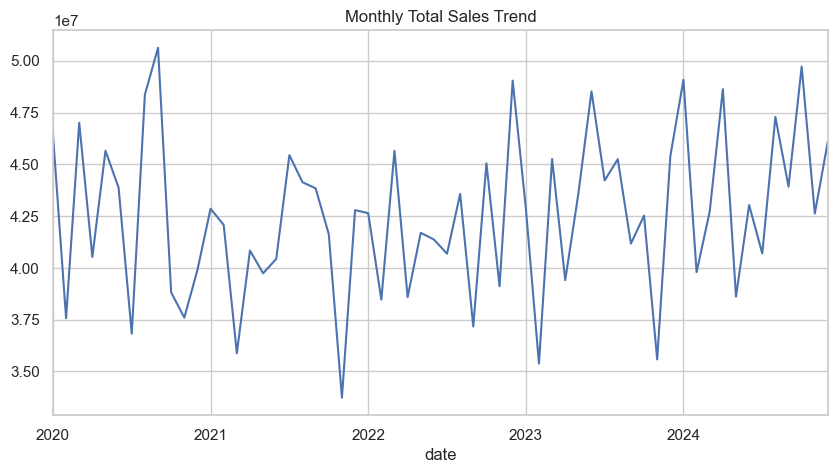

In [27]:
monthly_sales.plot(
    title='Monthly Total Sales Trend',
    figsize=(10,5)
)

### Trend Observation

The time series shows recurring peaks around similar months across years,
suggesting seasonal behavior. There are also noticeable periods of decline,
indicating potential demand fluctuations or external market effects.

### Train-Test Split

The dataset was split into training and testing sets based on time order.
The last 12 months were held out as test data to evaluate forecast performance
on unseen future observations.

In [28]:
train = monthly_sales.iloc[:-12]
test = monthly_sales.iloc[-12:]

In [30]:
train.shape, test.shape

((48,), (12,))

In [31]:
naive_forecast = test.copy()
naive_forecast[:] = train.iloc[-1]

In [32]:
from sklearn.metrics import mean_absolute_error

mae_naive = mean_absolute_error(test, naive_forecast)
mae_naive

3350916.198333334

### Baseline Forecast (Naïve Model)

The naïve model assumes future sales remain constant at the last observed value.
This serves as a baseline to compare more advanced forecasting methods.

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

hw_forecast = hw_model.forecast(12)

C:\Users\Precious\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### Model Convergence Note

During model fitting, a convergence warning was observed. This can occur in
real-world retail data due to noise, irregular patterns, or overlapping
seasonality. Despite the warning, the model produced stable forecasts and
evaluation metrics were used to validate performance.

In [35]:
mae_hw = mean_absolute_error(test, hw_forecast)
mae_hw

2836288.3511001

### Holt-Winters Forecast

The Holt-Winters model captures both trend and seasonal patterns.
It outperforms the naïve baseline, indicating the presence of structured
time-based behavior in retail sales.

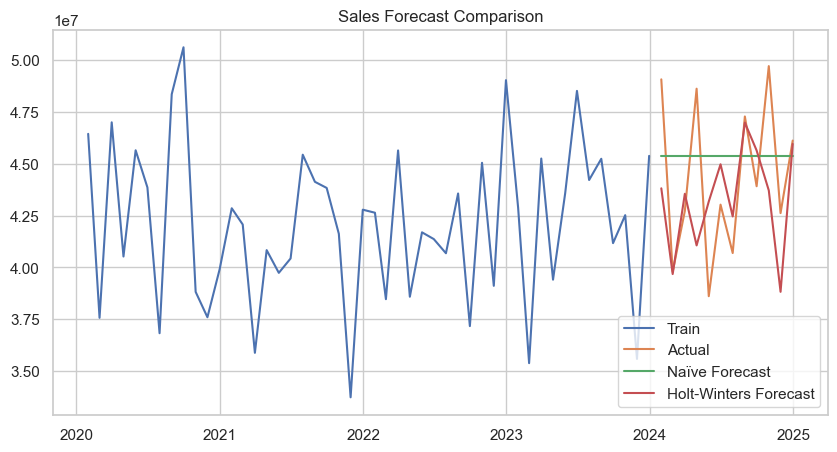

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, naive_forecast, label='Naïve Forecast')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast')
plt.legend()
plt.title('Sales Forecast Comparison')
plt.show()

### Forecast Comparison

The Holt-Winters model follows the seasonal movement of actual sales more
closely than the naïve model, demonstrating its effectiveness for retail
demand forecasting.